# I tried transfer learning from the subgroup model to the cluster level. Didn't seem to work well. Results can be ignored, methods can be re-used

In [ ]:
import anndata as ad
import crested
import numpy as np

2025-07-31 09:03:24.259428: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-31 09:03:24.818347: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753977805.040306 2529734 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753977805.102420 2529734 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-31 09:03:25.636425: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
import matplotlib
import matplotlib.pyplot as plt

# Set the font type to ensure text is saved as whole words
matplotlib.rcParams["pdf.fonttype"] = 42  # Use TrueType fonts instead of Type 3 fonts
matplotlib.rcParams["ps.fonttype"] = 42  # For PostScript as well, if needed

# First we check the peak normalization weight on the entire peak universe

In [13]:
bigwigs_folder = "/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/BasalGanglia_paper_package/data/human/ATAC/Astro_inGMSTR/results/"
regions_file = "/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/BasalGanglia_paper_package/data/human/ATAC/Astro_subGroup/results/whole_tax_merged_peaks.bed"
regions_file = "/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/BasalGanglia_paper_package/data/human/ATAC/Astro_inGMSTR/results/merged_peaks_astro_GMSTR_3clusters.bed"


In [14]:
import os

genome_fasta  = "/allen/programs/celltypes/workgroups/rnaseqanalysis/references/human/10x/grch38.p2/genome/fasta/genome.fa"

# if you ever need a .chrom.sizes (for change_regions_width etc)
chr_sizes     = os.path.abspath(
    os.path.join(os.path.dirname(genome_fasta), "../star/chrNameLength.txt")
)

genome = crested.Genome(
   genome_fasta, chr_sizes)

crested.register_genome(
    genome
)  # Register the genome so that it can be used by the package

print(genome.fetch("chr1", 10000, 10010))

2025-07-31T09:10:56.655122-0700 INFO Genome genome registered.
TAACCCTAAC


In [15]:
adata = crested.import_bigwigs(
    bigwigs_folder=bigwigs_folder,
    regions_file=regions_file,
    target_region_width=1000,
    target="count",
)
adata

2025-07-31T09:11:03.038973-0700 INFO Extracting values from 3 bigWig files...


AnnData object with n_obs × n_vars = 3 × 320189
    obs: 'file_path'
    var: 'chr', 'start', 'end'

In [16]:
adata.X = np.nan_to_num(adata.X, nan=0.0)

In [17]:
# Choose the chromosomes for the validation and test sets
crested.pp.train_val_test_split(
    adata, strategy="chr", val_chroms=["chr10"], test_chroms=["chr18"]
)

print(adata.var["split"].value_counts())
adata.var.head(3)

split
train    295662
val       16908
test       7619
Name: count, dtype: int64


,chr,start,end,split
region,,,,
GL000194.1:21905-22406,GL000194.1,21905,22406,train
GL000194.1:24960-25461,GL000194.1,24960,25461,train
GL000194.1:24260-24761,GL000194.1,24260,24761,train


In [18]:
crested.pp.change_regions_width(
    adata,
    2114,
)  # change the adata width of the regions to 2114bp

2025-07-31T09:11:14.776780-0700 WARNING Region GL000205.2:-609-1504 with coordinates GL000205.2:-609-1504 is out of bounds for chromosome GL000205.2. Removing region.
2025-07-31T09:11:14.780775-0700 WARNING Region GL000219.1:177696-179810 with coordinates GL000219.1:177696-179810 is out of bounds for chromosome GL000219.1. Removing region.
2025-07-31T09:11:14.781405-0700 WARNING Region GL000219.1:177190-179304 with coordinates GL000219.1:177190-179304 is out of bounds for chromosome GL000219.1. Removing region.


In [19]:
crested.pp.normalize_peaks(
    adata, top_k_percent=0.03
)  # The top_k_percent parameters can be tuned based on potential bias towards cell types. If some weights are overcompensating too much, consider increasing the top_k_percent. Default is 0.01

2025-07-31T09:11:30.996489-0700 INFO Filtering on top k Gini scores...
2025-07-31T09:11:31.467634-0700 INFO Added normalization weights to adata.obsm['weights']...


,chr,start,end,split
region,,,,
chr15:39933026-39935140,chr15,39933026,39935140,train
chr4:158671628-158673742,chr4,158671628,158673742,train
chr2:131092419-131094533,chr2,131092419,131094533,train
chr15:40038161-40040275,chr15,40038161,40040275,train
chr4:158767838-158769952,chr4,158767838,158769952,train
...,...,...,...,...
chr8:119872639-119874753,chr8,119872639,119874753,train
chr17:77450417-77452531,chr17,77450417,77452531,train
chr10:32345298-32347412,chr10,32345298,32347412,val


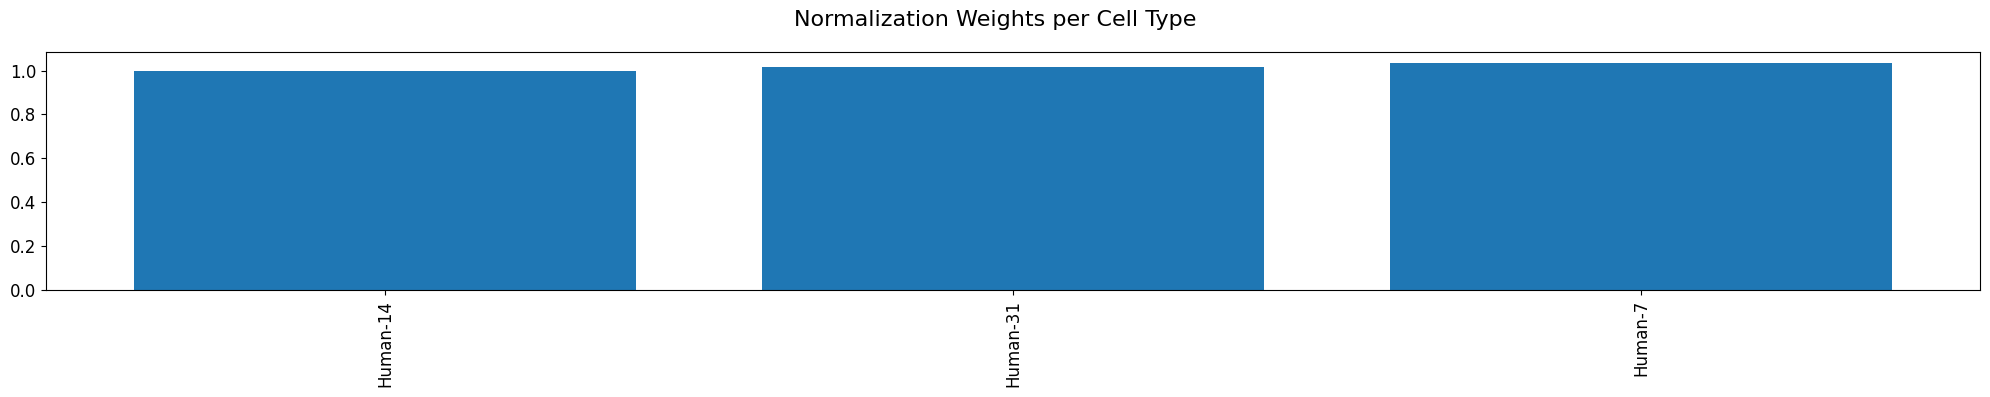

In [20]:
%matplotlib inline
crested.pl.bar.normalization_weights(
    adata, title="Normalization Weights per Cell Type", x_label_rotation=90, height=4
)

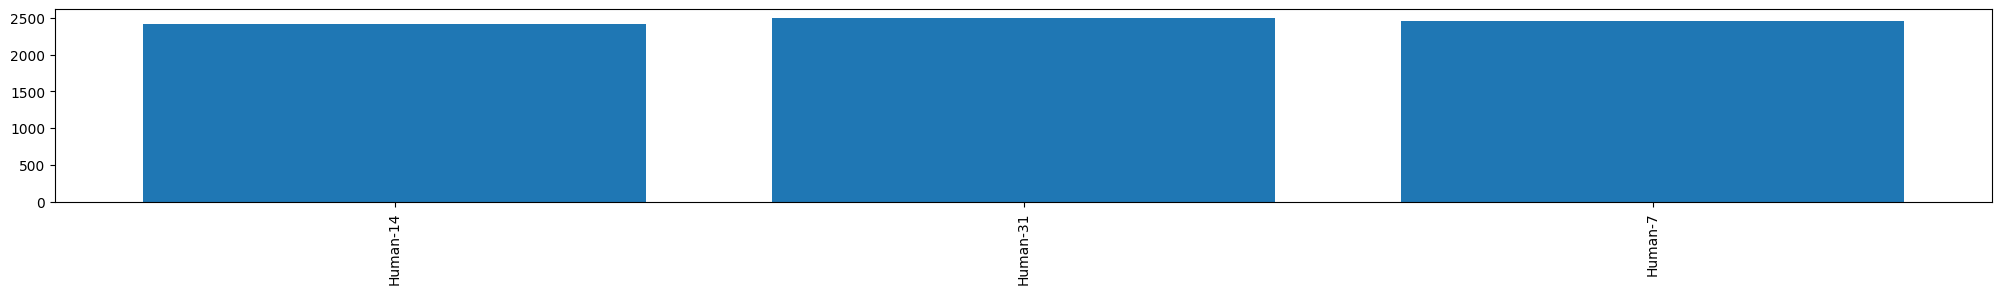

In [23]:
# Sanity checks
reg="chr2:131092419-131094533"	
idx = np.argwhere(adata.var.index==reg)[0,0]
plt.figure(figsize=(25,2.5))
plt.bar(adata.obs_names, adata.X.T[idx])
plt.xticks(rotation=90)
plt.show()

In [21]:
weights = adata.obsm['weights']
weights

array([1.       , 1.0146492, 1.03265  ], dtype=float32)

## Now we use these weights on the adata of the DAR set

In [47]:
bigwigs_folder = "/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/BasalGanglia_paper_package/data/human/ATAC/Astro_inGMSTR/results/"
regions_file = "/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/BasalGanglia_paper_package/data/human/ATAC/Astro_inGMSTR/results/unique_DAR_peaks_humanAstro_3Clusters_inGMSTR.bed"

In [48]:
adata = crested.import_bigwigs(
    bigwigs_folder=bigwigs_folder,
    regions_file=regions_file,
    target_region_width=1000,
    target="count",
)
adata

2025-07-31T09:38:28.555825-0700 INFO Extracting values from 3 bigWig files...


AnnData object with n_obs × n_vars = 3 × 13171
    obs: 'file_path'
    var: 'chr', 'start', 'end'

In [49]:
adata.X = np.nan_to_num(adata.X, nan=0.0)

In [50]:
# Choose the chromosomes for the validation and test sets
crested.pp.train_val_test_split(
    adata, strategy="chr", val_chroms=["chr10"], test_chroms=["chr18"]
)

print(adata.var["split"].value_counts())
adata.var.head(3)

split
train    12257
val        686
test       228
Name: count, dtype: int64


,chr,start,end,split
region,,,,
chr14:101457846-101458347,chr14,101457846,101458347,train
chr19:8592347-8592848,chr19,8592347,8592848,train
chr14:101458777-101459278,chr14,101458777,101459278,train


In [51]:
crested.pp.change_regions_width(
    adata,
    2114,
)  # change the adata width of the regions to 2114bp

In [52]:
adata.X[:,0]

array([ 612.007  ,  390.93228, 1851.5009 ], dtype=float32)

In [53]:
adata.X = adata.X * weights[:, np.newaxis]

In [54]:
adata.X[:,0]

array([ 612.007  ,  396.65912, 1911.9524 ], dtype=float32)

In [55]:
adata.write_h5ad("/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/evogen-dnaseq-modeling/basal_ganglia/dorsal_ventral_dars.h5ad")

# Load subgroup model for transfer learning

In [35]:
import keras

In [38]:
model_path_sg= "/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/astro_human/full_universe_base_subset_filtered_ft_2_dars_ft///checkpoints/05.keras"
model_sg = keras.models.load_model(model_path_sg, compile=False)

I0000 00:00:1753978695.695118 2529734 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38485 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:b1:00.0, compute capability: 8.0


In [43]:
# Freeze all layers in the base model
for layer in model_sg.layers:
    layer.trainable = False

# Rebuild the final classification head on top of the frozen base
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

# Extract input and the output just before the original Dense layer
input_layer = model_sg.input
penultimate_output = model_sg.get_layer("global_average_pooling1d").output

# Add new trainable classification head
new_output = Dense(3, activation='softplus', name='new_dense_out')(penultimate_output)

# Construct the new model
transfer_model = Model(inputs=input_layer, outputs=new_output)
transfer_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence            │ (None, 2114, 4)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 2114, 512) │     10,240 │ sequence[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 2114, 512) │      2,048 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 2114, 512) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2114, 512) │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_1conv         │ (None, 2110, 512) │    786,432 │ dropout[0][0]     │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_1bn           │ (None, 2110, 512) │      2,048 │ bpnet_1conv[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_1activation   │ (None, 2110, 512) │          0 │ bpnet_1bn[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_1crop         │ (None, 2110, 512) │          0 │ dropout[0][0]     │
│ (Cropping1D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 2110, 512) │          0 │ bpnet_1activatio… │
│                     │                   │            │ bpnet_1crop[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_1dropout      │ (None, 2110, 512) │          0 │ add[0][0]         │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_2conv         │ (None, 2102, 512) │    786,432 │ bpnet_1dropout[0… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_2bn           │ (None, 2102, 512) │      2,048 │ bpnet_2conv[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_2activation   │ (None, 2102, 512) │          0 │ bpnet_2bn[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_2crop         │ (None, 2102, 512) │          0 │ bpnet_1dropout[0… │
│ (Cropping1D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 2102, 512) │          0 │ bpnet_2activatio… │
│                     │                   │            │ bpnet_2crop[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_2dropout      │ (None, 2102, 512) │          0 │ add_1[0][0]       │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 6,321,667 (24.12 MB)

 Trainable params: 1,539 (6.01 KB)

 Non-trainable params: 6,320,128 (24.11 MB)

In [44]:
transfer_model.save("/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/dorsal_ventral/transfer_model_pt.keras")

## Train dense layer

In [56]:
import os
import subprocess

# === VARIABLES ===
GENOME_FASTA = "/allen/programs/celltypes/workgroups/rnaseqanalysis/references/human/10x/grch38.p2/genome/fasta/genome.fa"
CHR_SIZES = "/allen/programs/celltypes/workgroups/rnaseqanalysis/references/human/10x/grch38.p2/genome/star/chrNameLength.txt"
ADATA_PATH = "/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/evogen-dnaseq-modeling/basal_ganglia/astro/dorsal_ventral_dars.h5ad"
PROJECT_NAME = "astro_human"
RUN_NAME = "dorsal_ventral_TL"
LOGGER = "wandb"
BATCH_SIZE = 8
SEQ_LEN = 2114
MAX_SHIFT = 3
REVERSE_COMPLEMENT = "true"
LEARNING_RATE = 0.001
MAX_WEIGHT = 100
LOSS_MULTIPLIER = 1.0
FIRST_CONV_FILTERS = 512
NUM_FILTERS = 512
EPOCHS = 100
LR_PATIENCE = 3
EARLY_STOPPING_PATIENCE = 10
SEED = 7
PRETRAINED_MODEL_PATH = "/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/dorsal_ventral/transfer_model_pt.keras"

WORKDIR = "/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/evogen-dnaseq-modeling/basal_ganglia/astro/"
SCRIPT_PATH = "/home/niklas.kempynck/nkemp/software/HMBA_Genomics/SpinalCord/crested_analysis/train_crested_model.py"

# === ENV SETUP ===
os.chdir(WORKDIR)

# If you're using conda, subprocess must launch with the right environment externally.

# === BUILD CMD ===
cmd = [
    "python", SCRIPT_PATH,
    "--genome_fasta", GENOME_FASTA,
    "--chr_sizes", CHR_SIZES,
    "--adata_path", ADATA_PATH,
    "--project_name", PROJECT_NAME,
    "--run_name", RUN_NAME,
    "--logger", LOGGER,
    "--batch_size", str(BATCH_SIZE),
    "--seq_len", str(SEQ_LEN),
    "--max_stochastic_shift", str(MAX_SHIFT),
    "--always_reverse_complement", REVERSE_COMPLEMENT,
    "--learning_rate", str(LEARNING_RATE),
    "--max_weight", str(MAX_WEIGHT),
    "--loss_multiplier", str(LOSS_MULTIPLIER),
    "--epochs", str(EPOCHS),
    "--lr_patience", str(LR_PATIENCE),
    "--early_stopping_patience", str(EARLY_STOPPING_PATIENCE),
    "--first_conv_filters", str(FIRST_CONV_FILTERS),
    "--num_filters", str(NUM_FILTERS),
    "--seed", str(SEED),
]

if PRETRAINED_MODEL_PATH:
    cmd += ["--pretrained_model_path", PRETRAINED_MODEL_PATH]

print("Running training script:")
print(" ".join(cmd))

# === EXECUTE ===
subprocess.run(cmd, check=True)

Running training script:
python /home/niklas.kempynck/nkemp/software/HMBA_Genomics/SpinalCord/crested_analysis/train_crested_model.py --genome_fasta /allen/programs/celltypes/workgroups/rnaseqanalysis/references/human/10x/grch38.p2/genome/fasta/genome.fa --chr_sizes /allen/programs/celltypes/workgroups/rnaseqanalysis/references/human/10x/grch38.p2/genome/star/chrNameLength.txt --adata_path /allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/evogen-dnaseq-modeling/basal_ganglia/dorsal_ventral_dars.h5ad --project_name astro_human --run_name dorsal_ventral_TL --logger wandb --batch_size 8 --seq_len 2114 --max_stochastic_shift 3 --always_reverse_complement true --learning_rate 0.001 --max_weight 100 --loss_multiplier 1.0 --epochs 100 --lr_patience 3 --early_stopping_patience 10 --first_conv_filters 512 --num_filters 512 --seed 7 --pretrained_model_path /allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-oct

E0000 00:00:1753979930.943226 2531174 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753979930.947525 2531174 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Starting training script with arguments:
  genome_fasta: /allen/programs/celltypes/workgroups/rnaseqanalysis/references/human/10x/grch38.p2/genome/fasta/genome.fa
  chr_sizes: /allen/programs/celltypes/workgroups/rnaseqanalysis/references/human/10x/grch38.p2/genome/star/chrNameLength.txt
  adata_path: /allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/evogen-dnaseq-modeling/basal_ganglia/dorsal_ventral_dars.h5ad
  pretrained_model_path: /allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/dorsal_ventral/transfer_model_pt.keras
  batch_size: 8
  max_stochastic_shift: 3
  always_reverse_complement: True
  seq_len: 2114
  learning_rate: 0.001
  max_weight: 100.0
  loss_multiplier: 1.0
  project_name: astro_human
  run_name: dorsal_ventral_TL
  logger: wandb
  seed: 7
  first_conv_filters: 512
  num_filters: 512
  epochs: 100
  lr_patience: 

I0000 00:00:1753979944.846012 2531174 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 888 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:b1:00.0, compute capability: 8.0
wandb: Currently logged in as: nelsonj (allenai-team1) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.19.11
wandb: Run data is saved locally in /allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/evogen-dnaseq-modeling/basal_ganglia/astro/wandb/run-20250731_093908-l6jsj2do
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run dorsal_ventral_TL
wandb: ⭐️ View project at https://wandb.ai/allenai-team1/astro_human
wandb: 🚀 View run at https://wandb.ai/allenai-team1/astro_human/runs/l6jsj2do



[INFO] Loading AnnData from: /allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/evogen-dnaseq-modeling/basal_ganglia/dorsal_ventral_dars.h5ad
[INFO] Loaded AnnData with shape: (3, 13171)

[INFO] Creating AnnDataModule...

[INFO] Using default strategy (single GPU or CPU).

[INFO] Loading pretrained model from: /allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/dorsal_ventral/transfer_model_pt.keras

[INFO] Setting up optimizer, loss, and metrics...
Number of classes: 3

[INFO] Initializing trainer...

[INFO] Starting training for 100 epochs...
Model: "functional_2"
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence            │ (None, 2114, 4)   │

  0%|          | 0/686 [00:00<?, ?it/s]

2025-07-31T09:40:57.938163-0700 INFO Loading sequences into memory...


100%|██████████| 686/686 [00:04<00:00, 153.40it/s]


Epoch 1/100


I0000 00:00:1753980064.287531 2531235 service.cc:148] XLA service 0x7f6afc006f50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753980064.287890 2531235 service.cc:156]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
I0000 00:00:1753980064.716057 2531235 cuda_dnn.cc:529] Loaded cuDNN version 90600
I0000 00:00:1753980071.689148 2531235 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3065/3065 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - concordance_correlation_coefficient: 0.0013 - cosine_similarity: 0.9648 - loss: 0.7340 - mean_absolute_error: 731.7490 - mean_squared_error: 728284.8125 - multiclass_spearman_correlation: 0.3683 - pearson_correlation: 0.2496 - pearson_correlation_log: 0.1650 - zero_penalty_metric: 0.0000e+00 - val_concordance_correlation_coefficient: 0.0028 - val_cosine_similarity: 0.9646 - val_loss: 0.3519 - val_mean_absolute_error: 705.6072 - val_mean_squared_error: 662148.3125 - val_multiclass_spearman_correlation: 0.2948 - val_pearson_correlation: 0.4103 - val_pearson_correlation_log: 0.3886 - val_zero_penalty_metric: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
3065/3065 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - concordance_correlation_coefficient: 0.0050 - cosine_similarity: 0.9661 - loss: 0.2981 - mean_absolute_error: 707.3925 - mean_squared_error: 691340.5625 - multiclass_spearman_correlation: 0.3576 - pearson_correlation: 0.4208 - pearson_correlation_

wandb: uploading output.log; uploading wandb-summary.json
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                              batch/batch_step ▁▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇████████
wandb:     batch/concordance_correlation_coefficient ▁▁▁▁▁▁▁▂▅▅▆▆▇▇▇▇▇███████████████████████
wandb:                       batch/cosine_similarity ▅▆▆▅▅▅▆▆▄▄▂▁▁▃▄▅▇▅▆▇▇▇▇▇▇█▇█▇█▇▇▇▇▇▇▇█▇▇
wandb:                           batch/learning_rate █████████████████████▃▃▃▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                                    batch/loss █▆▅▅▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     batch/mean_absolute_error █████▆▆▂▂▁▂▁▁▁▁▁���▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                      batch/mean_squared_error ██▇▇▇▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:         batch/multiclass_spearman_correlation ▃▃▂▂▂▁▂▄▄▄▆▆▆▆▆▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇█▇▆▇▇▇▇▇▇
wandb:                     batch/pearson_correlation ▄▄▁▂▅▇▇▇▇▇▇▇▇▇▇▇▇▇██


[INFO] Training completed.


CompletedProcess(args=['python', '/home/niklas.kempynck/nkemp/software/HMBA_Genomics/SpinalCord/crested_analysis/train_crested_model.py', '--genome_fasta', '/allen/programs/celltypes/workgroups/rnaseqanalysis/references/human/10x/grch38.p2/genome/fasta/genome.fa', '--chr_sizes', '/allen/programs/celltypes/workgroups/rnaseqanalysis/references/human/10x/grch38.p2/genome/star/chrNameLength.txt', '--adata_path', '/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/evogen-dnaseq-modeling/basal_ganglia/dorsal_ventral_dars.h5ad', '--project_name', 'astro_human', '--run_name', 'dorsal_ventral_TL', '--logger', 'wandb', '--batch_size', '8', '--seq_len', '2114', '--max_stochastic_shift', '3', '--always_reverse_complement', 'true', '--learning_rate', '0.001', '--max_weight', '100', '--loss_multiplier', '1.0', '--epochs', '100', '--lr_patience', '3', '--early_stopping_patience', '10', '--first_conv_filters', '512', '--num_filters', 

## Load TL model, unfreeze layers

In [63]:
model_path_tl= "/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/astro_human/dorsal_ventral_TL/12.keras"
model_tl = keras.models.load_model(model_path_sg, compile=False)
# Freeze all layers in the base model
for layer in model_tl.layers:
    layer.trainable = True
model_tl.summary()

model_tl.save("/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/astro_human/dorsal_ventral_TL/12.keras")  


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence            │ (None, 2114, 4)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 2114, 512) │     10,240 │ sequence[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 2114, 512) │      2,048 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 2114, 512) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2114, 512) │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_1conv         │ (None, 2110, 512) │    786,432 │ dropout[0][0]     │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_1bn           │ (None, 2110, 512) │      2,048 │ bpnet_1conv[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_1activation   │ (None, 2110, 512) │          0 │ bpnet_1bn[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_1crop         │ (None, 2110, 512) │          0 │ dropout[0][0]     │
│ (Cropping1D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 2110, 512) │          0 │ bpnet_1activatio… │
│                     │                   │            │ bpnet_1crop[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_1dropout      │ (None, 2110, 512) │          0 │ add[0][0]         │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_2conv         │ (None, 2102, 512) │    786,432 │ bpnet_1dropout[0… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_2bn           │ (None, 2102, 512) │      2,048 │ bpnet_2conv[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_2activation   │ (None, 2102, 512) │          0 │ bpnet_2bn[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_2crop         │ (None, 2102, 512) │          0 │ bpnet_1dropout[0… │
│ (Cropping1D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 2102, 512) │          0 │ bpnet_2activatio… │
│                     │                   │            │ bpnet_2crop[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_2dropout      │ (None, 2102, 512) │          0 │ add_1[0][0]       │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 6,321,667 (24.12 MB)

 Trainable params: 6,312,451 (24.08 MB)

 Non-trainable params: 9,216 (36.00 KB)

In [65]:
import os
import subprocess

# === VARIABLES ===
GENOME_FASTA = "/allen/programs/celltypes/workgroups/rnaseqanalysis/references/human/10x/grch38.p2/genome/fasta/genome.fa"
CHR_SIZES = "/allen/programs/celltypes/workgroups/rnaseqanalysis/references/human/10x/grch38.p2/genome/star/chrNameLength.txt"
ADATA_PATH = "/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/evogen-dnaseq-modeling/basal_ganglia/astro/dorsal_ventral_dars.h5ad"
PROJECT_NAME = "astro_human"
RUN_NAME = "dorsal_ventral_FT_2"
LOGGER = "wandb"
BATCH_SIZE = 4
SEQ_LEN = 2114
MAX_SHIFT = 3
REVERSE_COMPLEMENT = "true"
LEARNING_RATE = 0.00001
MAX_WEIGHT = 100
LOSS_MULTIPLIER = 1.0
FIRST_CONV_FILTERS = 512
NUM_FILTERS = 512
EPOCHS = 100
LR_PATIENCE = 3
EARLY_STOPPING_PATIENCE = 10
SEED = 7
PRETRAINED_MODEL_PATH = "/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/astro_human/dorsal_ventral_TL/12.keras"

WORKDIR = "/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/"
SCRIPT_PATH = "/home/niklas.kempynck/nkemp/software/HMBA_Genomics/SpinalCord/crested_analysis/train_crested_model.py"

# === ENV SETUP ===
os.chdir(WORKDIR)

# If you're using conda, subprocess must launch with the right environment externally.

# === BUILD CMD ===
cmd = [
    "python", SCRIPT_PATH,
    "--genome_fasta", GENOME_FASTA,
    "--chr_sizes", CHR_SIZES,
    "--adata_path", ADATA_PATH,
    "--project_name", PROJECT_NAME,
    "--run_name", RUN_NAME,
    "--logger", LOGGER,
    "--batch_size", str(BATCH_SIZE),
    "--seq_len", str(SEQ_LEN),
    "--max_stochastic_shift", str(MAX_SHIFT),
    "--always_reverse_complement", REVERSE_COMPLEMENT,
    "--learning_rate", str(LEARNING_RATE),
    "--max_weight", str(MAX_WEIGHT),
    "--loss_multiplier", str(LOSS_MULTIPLIER),
    "--epochs", str(EPOCHS),
    "--lr_patience", str(LR_PATIENCE),
    "--early_stopping_patience", str(EARLY_STOPPING_PATIENCE),
    "--first_conv_filters", str(FIRST_CONV_FILTERS),
    "--num_filters", str(NUM_FILTERS),
    "--seed", str(SEED),
]

if PRETRAINED_MODEL_PATH:
    cmd += ["--pretrained_model_path", PRETRAINED_MODEL_PATH]

print("Running training script:")
print(" ".join(cmd))

# === EXECUTE ===
subprocess.run(cmd, check=True)

Running training script:
python /home/niklas.kempynck/nkemp/software/HMBA_Genomics/SpinalCord/crested_analysis/train_crested_model.py --genome_fasta /allen/programs/celltypes/workgroups/rnaseqanalysis/references/human/10x/grch38.p2/genome/fasta/genome.fa --chr_sizes /allen/programs/celltypes/workgroups/rnaseqanalysis/references/human/10x/grch38.p2/genome/star/chrNameLength.txt --adata_path /allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/evogen-dnaseq-modeling/basal_ganglia/astro/dorsal_ventral_dars.h5ad --project_name astro_human --run_name dorsal_ventral_FT_2 --logger wandb --batch_size 4 --seq_len 2114 --max_stochastic_shift 3 --always_reverse_complement true --learning_rate 1e-05 --max_weight 100 --loss_multiplier 1.0 --epochs 100 --lr_patience 3 --early_stopping_patience 10 --first_conv_filters 512 --num_filters 512 --seed 7 --pretrained_model_path /allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/

E0000 00:00:1753996795.642629 2541708 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753996795.646992 2541708 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Starting training script with arguments:
  genome_fasta: /allen/programs/celltypes/workgroups/rnaseqanalysis/references/human/10x/grch38.p2/genome/fasta/genome.fa
  chr_sizes: /allen/programs/celltypes/workgroups/rnaseqanalysis/references/human/10x/grch38.p2/genome/star/chrNameLength.txt
  adata_path: /allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/evogen-dnaseq-modeling/basal_ganglia/astro/dorsal_ventral_dars.h5ad
  pretrained_model_path: /allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/astro_human/dorsal_ventral_TL/12.keras
  batch_size: 4
  max_stochastic_shift: 3
  always_reverse_complement: True
  seq_len: 2114
  learning_rate: 1e-05
  max_weight: 100.0
  loss_multiplier: 1.0
  project_name: astro_human
  run_name: dorsal_ventral_FT_2
  logger: wandb
  seed: 7
  first_conv_filters: 512
  num_filters: 512
  epochs: 100
  lr_pa

I0000 00:00:1753996809.812820 2541708 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 888 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:b1:00.0, compute capability: 8.0
wandb: Currently logged in as: nelsonj (allenai-team1) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.19.11
wandb: Run data is saved locally in /allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/wandb/run-20250731_142014-x610czc4
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run dorsal_ventral_FT_2
wandb: ⭐️ View project at https://wandb.ai/allenai-team1/astro_human
wandb: 🚀 View run at https://wandb.ai/allenai-team1/astro_human/runs/x610czc4



[INFO] Loading AnnData from: /allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/evogen-dnaseq-modeling/basal_ganglia/astro/dorsal_ventral_dars.h5ad
[INFO] Loaded AnnData with shape: (3, 13171)

[INFO] Creating AnnDataModule...

[INFO] Using default strategy (single GPU or CPU).

[INFO] Loading pretrained model from: /allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/astro_human/dorsal_ventral_TL/12.keras

[INFO] Setting up optimizer, loss, and metrics...
Number of classes: 3

[INFO] Initializing trainer...

[INFO] Starting training for 100 epochs...
Model: "functional"
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence            │ (None, 2114, 4)

100%|██████████| 686/686 [00:00<00:00, 87904.57it/s]


2025-07-31T14:20:15.568973-0700 INFO Loading sequences into memory...
Epoch 1/100


I0000 00:00:1753996819.285375 2541755 service.cc:148] XLA service 0x7fc540002380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753996819.285404 2541755 service.cc:156]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
I0000 00:00:1753996819.983102 2541755 cuda_dnn.cc:529] Loaded cuDNN version 90600
I0000 00:00:1753996830.923863 2541755 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6129/6129 ━━━━━━━━━━━━━━━━━━━━ 98s 14ms/step - concordance_correlation_coefficient: 0.0276 - cosine_similarity: 0.9587 - loss: 0.1099 - mean_absolute_error: 560.0974 - mean_squared_error: 493728.0312 - multiclass_spearman_correlation: 0.2666 - pearson_correlation: 0.2984 - pearson_correlation_log: 0.2790 - zero_penalty_metric: 0.0000e+00 - val_concordance_correlation_coefficient: 0.0945 - val_cosine_similarity: 0.9607 - val_loss: 0.0941 - val_mean_absolute_error: 521.5574 - val_mean_squared_error: 404976.8750 - val_multiclass_spearman_correlation: 0.2562 - val_pearson_correlation: 0.4105 - val_pearson_correlation_log: 0.3892 - val_zero_penalty_metric: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 2/100
6129/6129 ━━━━━━━━━━━━━━━━━━━━ 71s 12ms/step - concordance_correlation_coefficient: 0.0290 - cosine_similarity: 0.9620 - loss: 0.0771 - mean_absolute_error: 537.7158 - mean_squared_error: 469242.6250 - multiclass_spearman_correlation: 0.2786 - pearson_correlation: 0.3023 - pearson_correla

KeyboardInterrupt: 

# Model eval

In [95]:
model_path_tl= "/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/astro_human/dorsal_ventral_TL/12.keras"
model_path_ft= "/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/astro_human/dorsal_ventral_FT_2/checkpoints/02.keras"


In [96]:
model_tl = keras.models.load_model(model_path_tl, compile=False)
model_ft = keras.models.load_model(model_path_ft, compile=False)

In [97]:
import pysam
from tqdm import tqdm
fasta = pysam.FastaFile(genome_fasta)

seqs = [
    fasta.fetch(chrom, start, end)
    for chrom, start, end in tqdm(zip(adata.var['chr'], adata.var['start'], adata.var['end']))
]

13171it [00:00, 106237.09it/s]


In [98]:
# store predictions for all our regions in the anndata object for later inspection.
names = ['TL', 'TL_FT']
#for m, n in zip([model, model_2, model_ft, model_ft_2, model_dar, model_dar_2, model_dar_3], names):
for m, n in zip([model_tl, model_ft], names):
    predictions = crested.tl.predict(seqs, m, verbose=2)
    adata.layers[n] =predictions.T  # adata expects (C, N) instead of (N, C)

103/103 - 8s - 77ms/step
103/103 - 8s - 78ms/step


In [99]:
# Define a dataframe with test set regions
test_df = adata.var[adata.var["split"] == "test"]
test_df

,chr,start,end,split
region,,,,
chr18:74411194-74413308,chr18,74411194,74413308,test
chr18:79750212-79752326,chr18,79750212,79752326,test
chr18:77057582-77059696,chr18,77057582,77059696,test
chr18:59386480-59388594,chr18,59386480,59388594,test
chr18:37501275-37503389,chr18,37501275,37503389,test
...,...,...,...,...
chr18:27056968-27059082,chr18,27056968,27059082,test
chr18:26868681-26870795,chr18,26868681,26870795,test
chr18:26868061-26870175,chr18,26868061,26870175,test


chr18:37334005-37336119
2025-07-31T15:34:57.860611-0700 INFO Plotting bar plots for region: chr18:37334005-37336119, models: ['TL', 'TL_FT']


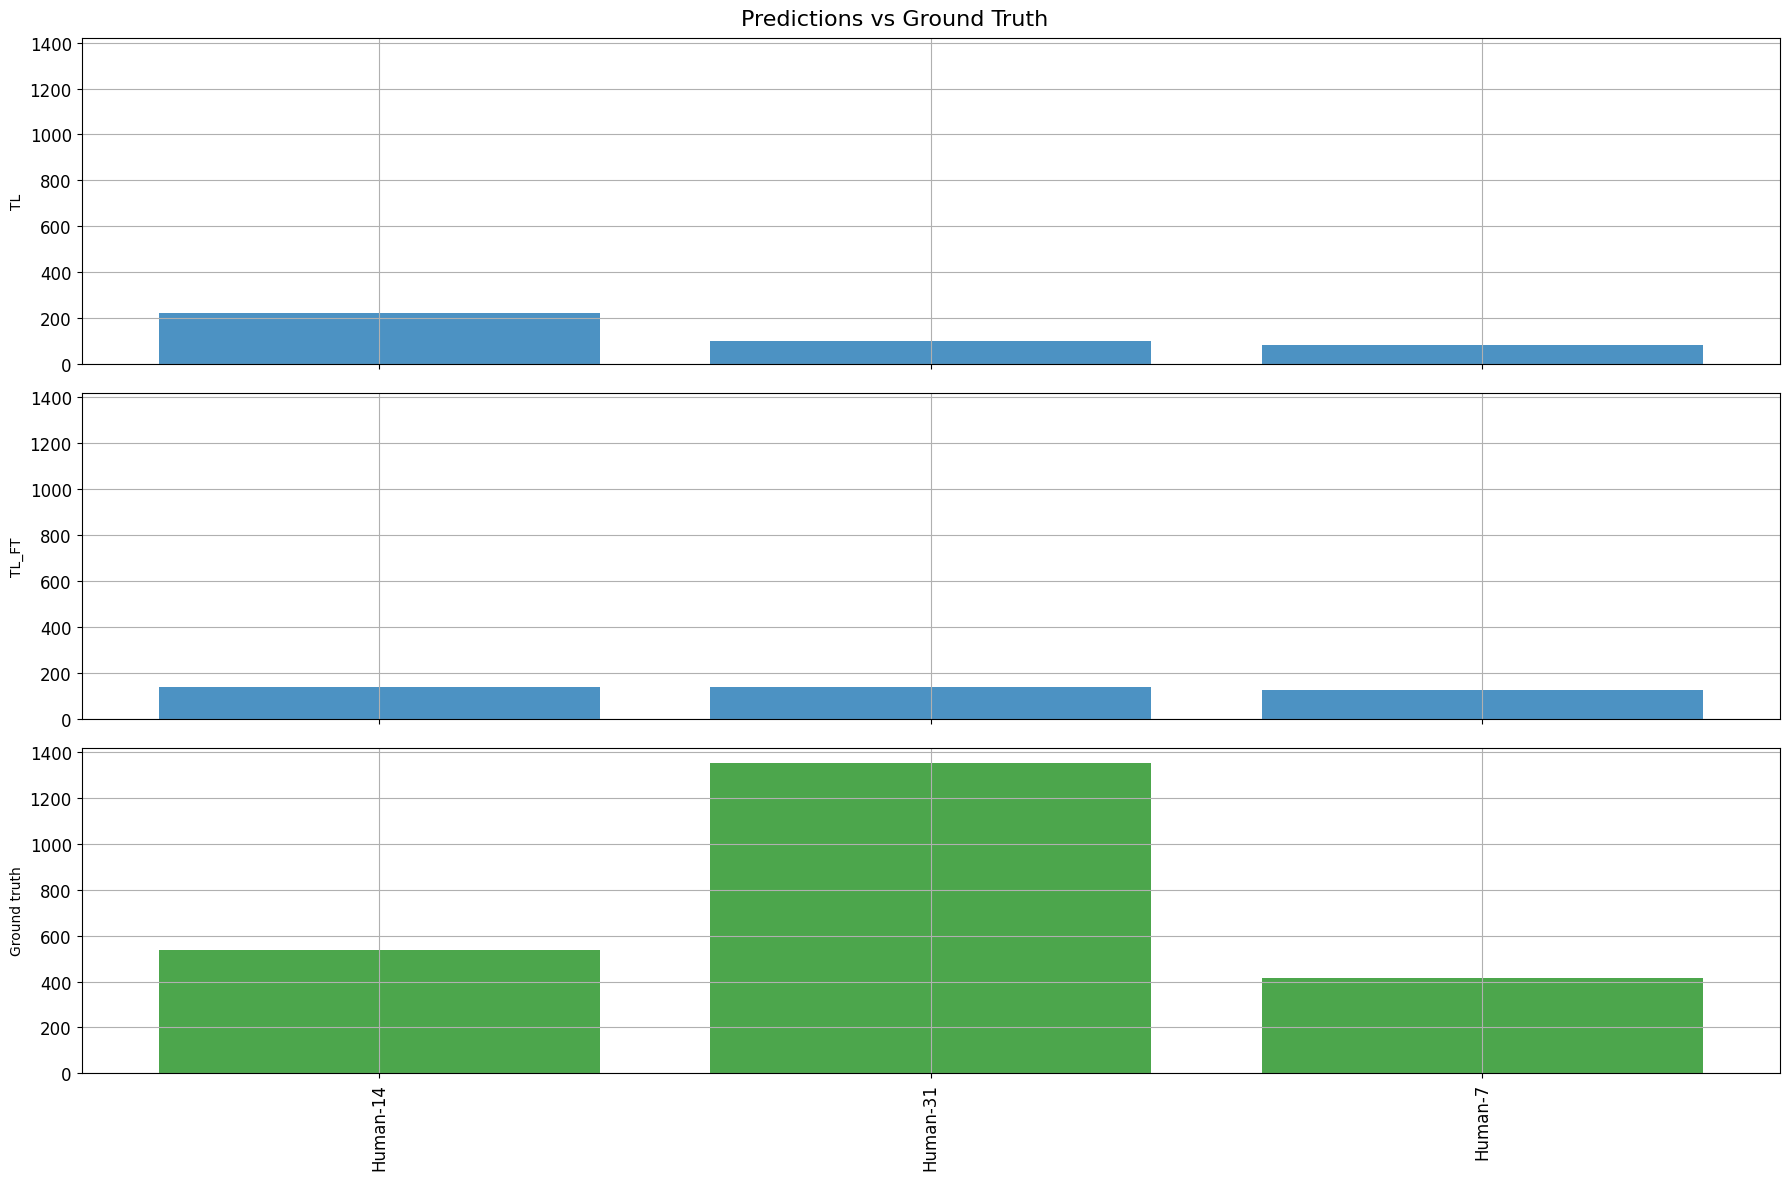

In [123]:
%matplotlib inline
# plot predictions vs ground truth for a random region in the test set defined by index
idx =31
region = test_df.index[idx]
print(region)
chrom = region.split(':')[0]
start = int(region.split(':')[1].split('-')[0])
end=start+2114
sequence = genome.fetch(chrom, start, end)
#prediction_tl = crested.tl.predict(sequence, model_tl)
#prediction_ft = crested.tl.predict(sequence, model_ft)


#crested.pl.bar.prediction(prediction, classes=list(adata.obs_names))
#crested.pl.bar.prediction(prediction_ft, classes=list(adata.obs_names))

crested.pl.bar.region_predictions(adata, region, title="Predictions vs Ground Truth", x_label_rotation=90)

2025-07-31T15:33:10.036345-0700 INFO Plotting density scatter for all targets and predictions, models: ['TL', 'TL_FT'], split: test


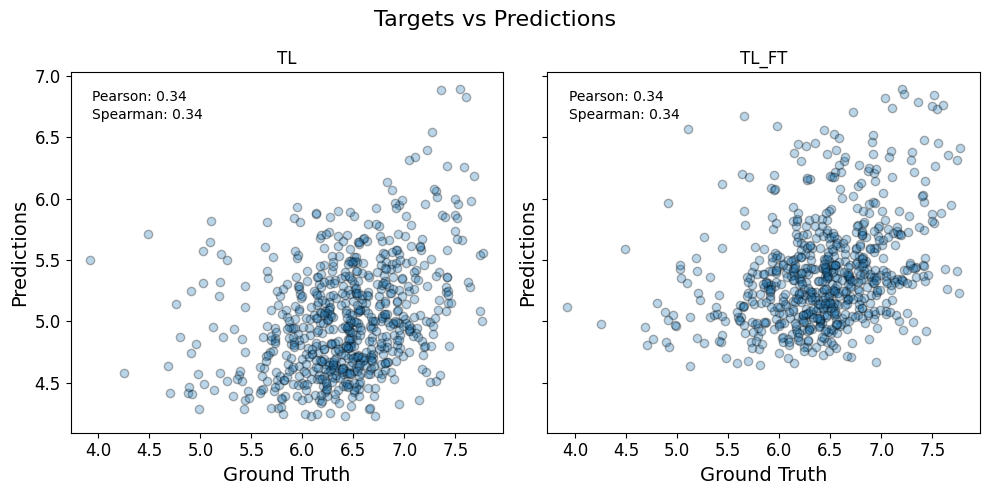

In [118]:
classn = None#"Ependymal"
crested.pl.scatter.class_density(
    adata,
    class_name=classn,
    model_names=None,
    split="test",
    log_transform=True,
    width=5*len(names),
    height=5,
    alpha=0.3,
)

2025-07-31T15:33:11.493876-0700 INFO Plotting heatmap correlations for split: test, models: ['TL', 'TL_FT']


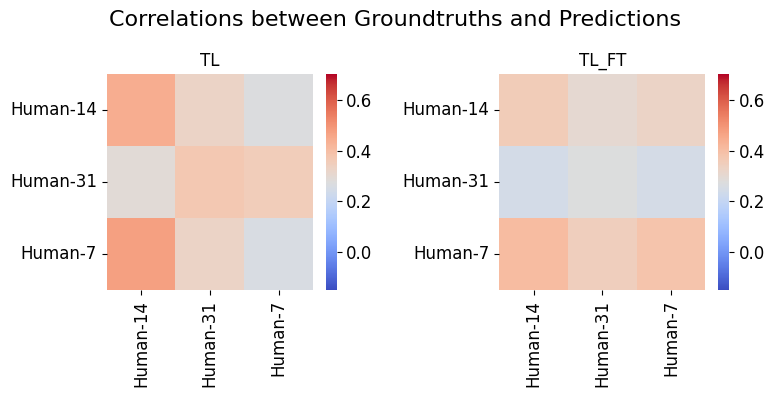

In [119]:
crested.pl.heatmap.correlations_predictions(
    adata,
    split="test",
    title="Correlations between Groundtruths and Predictions",
    x_label_rotation=90,
    width=4*len(names),
    height=4,
    log_transform=True,
    vmax=0.7,
    vmin=-0.15,
)

In [120]:
# plot predictions vs ground truth for a random region in the test set defined by index
region = test_df.index[idx]
classes_of_interest = ['Human-14', 'Human-31', 'Human-7']
class_idx = list(adata.obs_names.get_indexer(classes_of_interest))
scores, one_hot_encoded_sequences = crested.tl.contribution_scores(
    region,
    target_idx=class_idx,
    model=model_tl,
    method='integrated_grad'
)
scores_2, one_hot_encoded_sequences = crested.tl.contribution_scores(
    region,
    target_idx=class_idx,
    model=model_ft,
    method='integrated_grad'
)

2025-07-31T15:33:12.413843-0700 INFO Calculating contribution scores for 3 class(es) and 1 region(s).


Model: 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]

2025-07-31T15:33:12.693511-0700 INFO Calculating contribution scores for 3 class(es) and 1 region(s).



Model: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


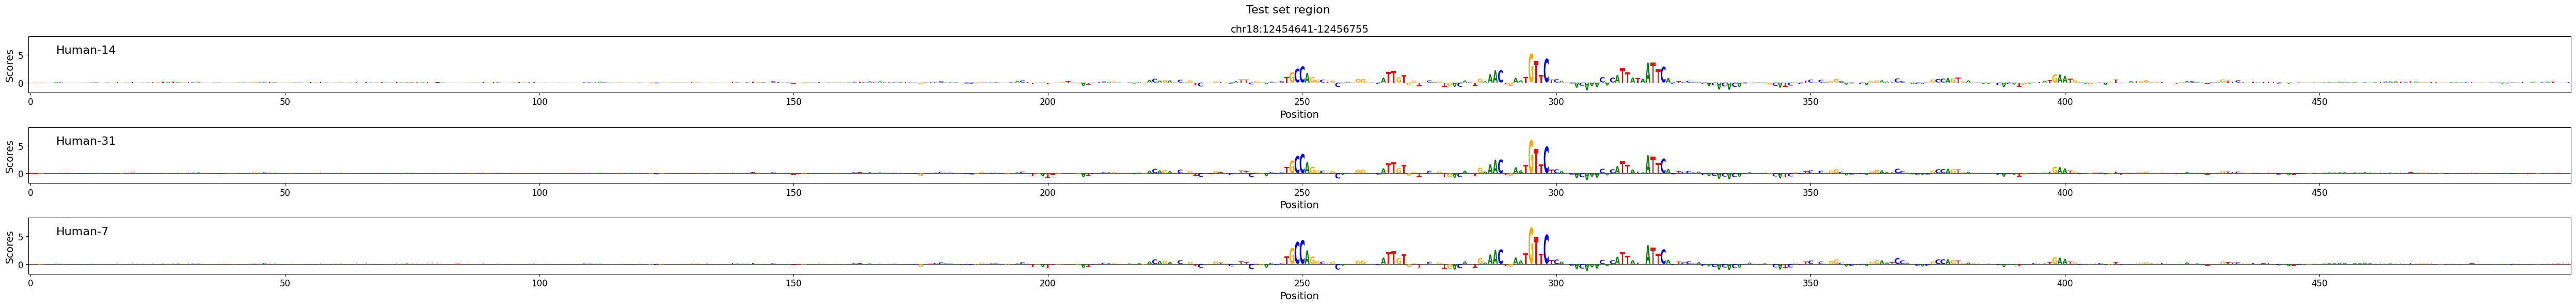

In [121]:
crested.pl.patterns.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    sequence_labels=[region],
    class_labels=classes_of_interest,
    zoom_n_bases=500,
    title="Test set region",
)  # zoom in on the center 500bp

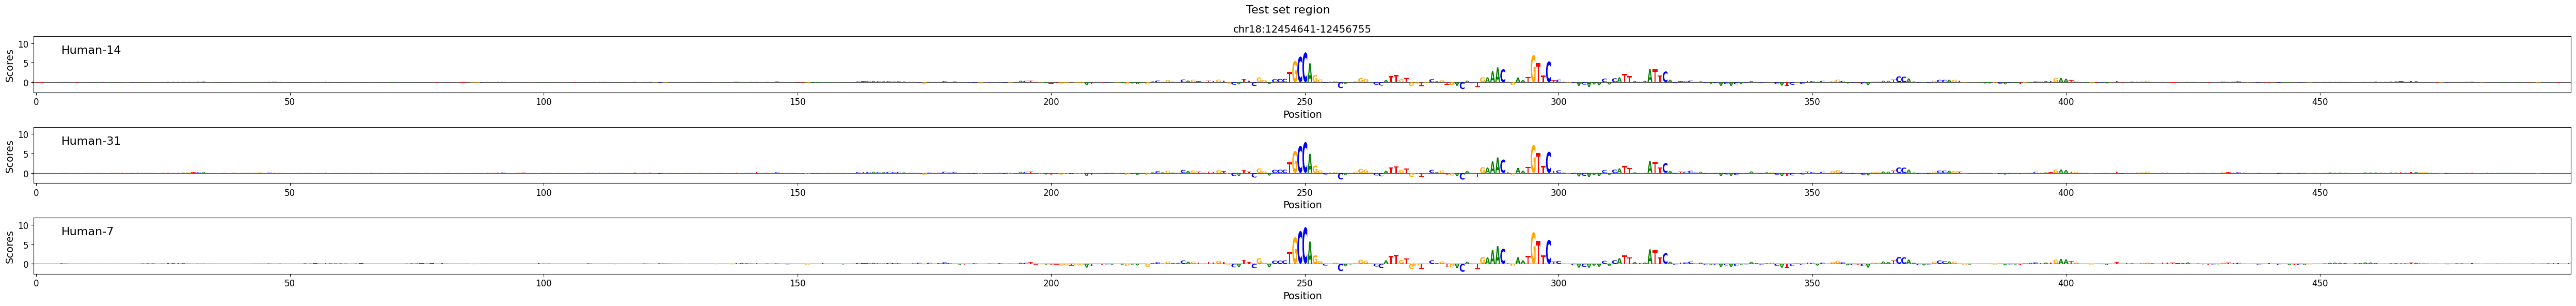

In [122]:
crested.pl.patterns.contribution_scores(
    scores_2,
    one_hot_encoded_sequences,
    sequence_labels=[region],
    class_labels=classes_of_interest,
    zoom_n_bases=500,
    title="Test set region",
)  # zoom in on the center 500bp